<a href="https://colab.research.google.com/github/dip-prog/dip-07/blob/master/ISIC_dataset_vgg_net_16_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download wanderdust/skin-lesion-analysis-toward-melanoma-detection

100% 11.3G/11.3G [08:28<00:00, 24.7MB/s]
100% 11.3G/11.3G [08:28<00:00, 23.9MB/s]


In [7]:
! unzip /content/skin-lesion-analysis-toward-melanoma-detection.zip

Archive:  /content/skin-lesion-analysis-toward-melanoma-detection.zip
  inflating: skin-lesions/test/melanoma/ISIC_0012258.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012356.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012369.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012395.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012425.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012758.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012989.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013072.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013073.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013242.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013277.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013321.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013374.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013411.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013414.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [9]:
dataset_dir = '/content/skin-lesions'


In [10]:
# Set the image size and batch size for training
image_size = (224, 224)
batch_size = 16

In [11]:
# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
# Load the training dataset
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2000 images belonging to 3 classes.


In [13]:
# Data normalization for validation and testing
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [14]:
# Load the validation dataset
val_generator = val_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'valid'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 150 images belonging to 3 classes.


In [15]:
# Create the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [16]:
# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False


In [17]:
# Create the new model with additional layers for classification
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))

In [18]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size)

Epoch 1/10
125/125 [==============================] - 252s 2s/step - loss: 1.3950 - accuracy: 0.6005 - val_loss: 0.9499 - val_accuracy: 0.4931
Epoch 2/10
125/125 [==============================] - 232s 2s/step - loss: 0.8839 - accuracy: 0.6755 - val_loss: 1.0002 - val_accuracy: 0.5069
Epoch 3/10
125/125 [==============================] - 222s 2s/step - loss: 0.8335 - accuracy: 0.6835 - val_loss: 1.0130 - val_accuracy: 0.5208
Epoch 4/10
125/125 [==============================] - 241s 2s/step - loss: 0.8305 - accuracy: 0.6860 - val_loss: 1.0356 - val_accuracy: 0.5208
Epoch 5/10
125/125 [==============================] - 227s 2s/step - loss: 0.8274 - accuracy: 0.6845 - val_loss: 1.0700 - val_accuracy: 0.5069
Epoch 6/10
125/125 [==============================] - 234s 2s/step - loss: 0.8381 - accuracy: 0.6860 - val_loss: 1.0899 - val_accuracy: 0.5139
Epoch 7/10
125/125 [==============================] - 237s 2s/step - loss: 0.8306 - accuracy: 0.6860 - val_loss: 1.0460 - val_accuracy: 0.5347

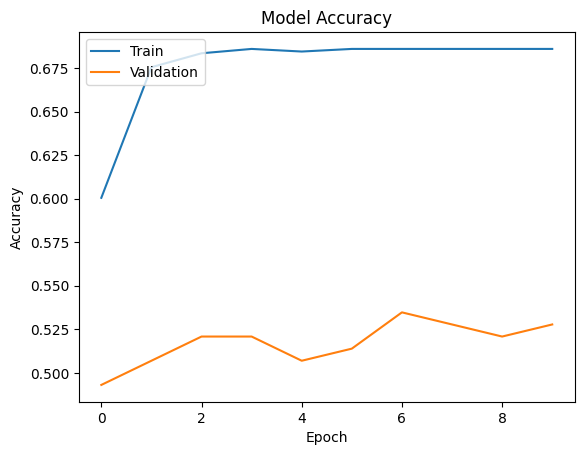

In [21]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

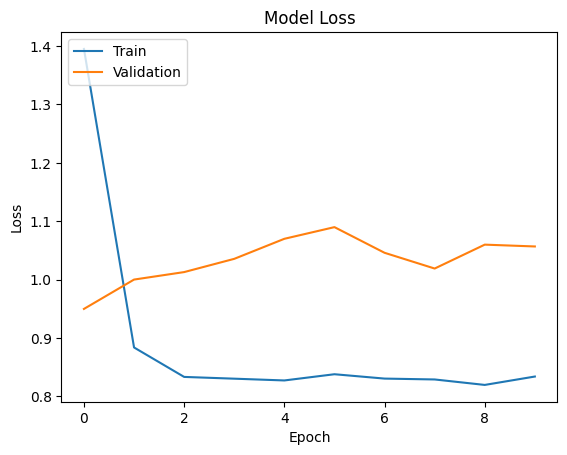

In [22]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

10/10 [==============================] - 24s 2s/step


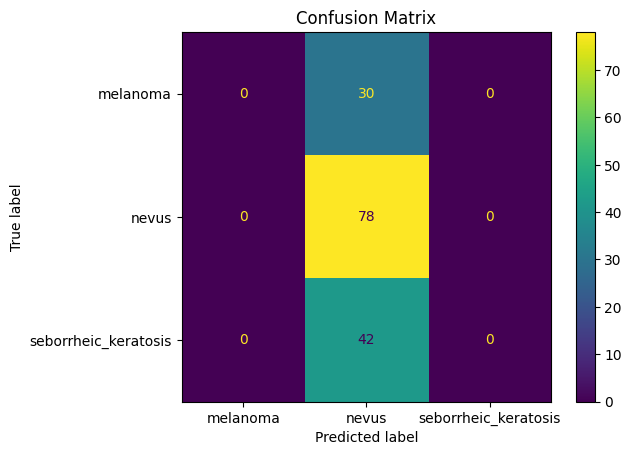

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#  the true labels and predicted labels for the validation dataset
y_true = val_generator.classes
y_pred = model.predict(val_generator).argmax(axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

10/10 [==============================] - 25s 2s/step


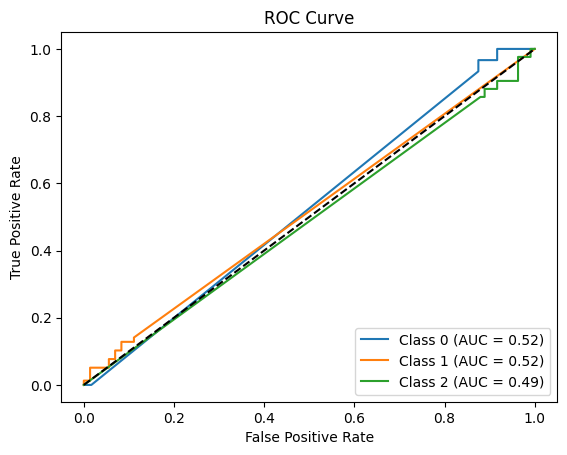

In [25]:
from sklearn.metrics import roc_curve, auc

# Get the probabilities for each class (0 and 1) from the model predictions
y_prob = model.predict(val_generator)

# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
